In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
                gm2: {$gt: 0.005, $lt: 0.011}
            },
        },
        {
            $project: {
                tag: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 6]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

Done!


In [4]:
from dltools.cov import cov111


@f.udf(ArrayType(BooleanType()))
def ishit0(arr):
    return [
        True if "C1p" in d else False
        for d in arr
    ]


pipico = cov111(
    df.select(ishit0(f.col("hits.as_")).alias("isthehit"),
              f.col("hits.t").alias("t")),
    "isthehit", "t", "t",
)

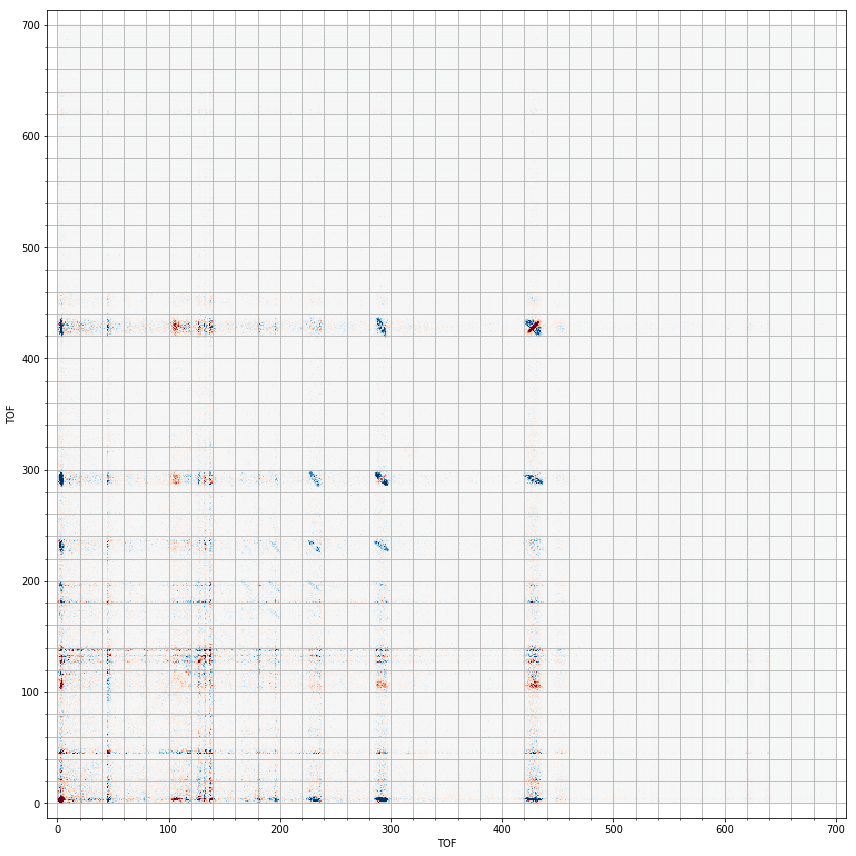

In [8]:
d = pipico(
    fr0=0, to0=2, nbins0=2,
    fr1=1000, to1=8000, nbins1=700,
    fr2=1000, to2=8000, nbins2=700)
img = d["Cov[X,Y,Z]"][1] * d["N"]

plt.figure(figsize=(12, 12))
plt.xlabel("TOF")
plt.ylabel("TOF")
plt.pcolormesh(img.T, cmap="RdBu")
# plt.colorbar()
plt.clim(-2e1, 2e1)
plt.minorticks_on()
plt.grid(True, which="both")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [9]:
from dltools.cov import cov111


@f.udf(ArrayType(BooleanType()))
def ishit0(arr):
    return [
        True if "C2p" in d else False
        # True if "C2p" in d and 0 < d["C2p"]["pz"] else False
        for d in arr
    ]


pipico = cov111(
    df.select(ishit0(f.col("hits.as_")).alias("isthehit"),
              f.col("hits.t").alias("t")),
    "isthehit", "t", "t",
)

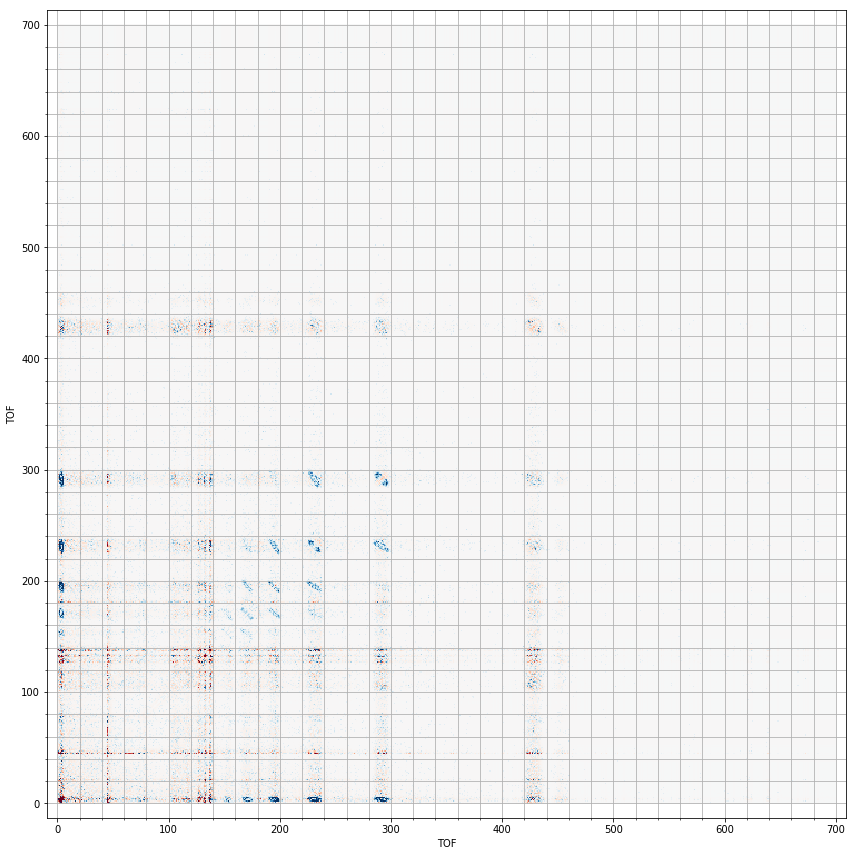

In [13]:
d = pipico(
    fr0=0, to0=2, nbins0=2,
    fr1=1000, to1=8000, nbins1=700,
    fr2=1000, to2=8000, nbins2=700)
img = d["Cov[X,Y,Z]"][1] * d["N"]

plt.figure(figsize=(12, 12))
plt.xlabel("TOF")
plt.ylabel("TOF")
plt.pcolormesh(img.T, cmap="RdBu")
# plt.colorbar()
plt.clim(-1e1, 1e1)
plt.minorticks_on()
plt.grid(True, which="both")
plt.axis("equal")
plt.tight_layout()
plt.show()

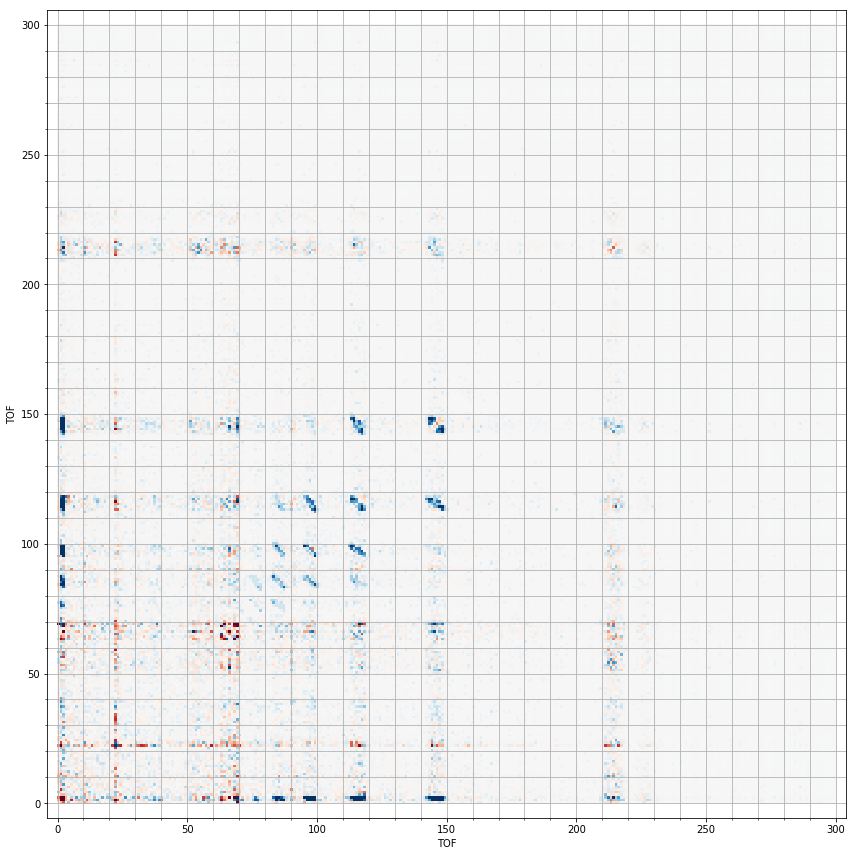

In [15]:
d = pipico(
    fr0=0, to0=2, nbins0=2,
    fr1=1000, to1=7000, nbins1=300,
    fr2=1000, to2=7000, nbins2=300)
img = d["Cov[X,Y,Z]"][1] * d["N"]

plt.figure(figsize=(12, 12))
plt.xlabel("TOF")
plt.ylabel("TOF")
plt.pcolormesh(img.T, cmap="RdBu")
# plt.colorbar()
plt.clim(-2e1, 2e1)
plt.minorticks_on()
plt.grid(True, which="both")
plt.axis("equal")
plt.tight_layout()
plt.show()